# ①ボックスのピクセル値の変化で判別する方法

In [19]:
from typing import Final as const, Any
from dataclasses import dataclass
import numpy as np
#openCVによるチェックマークの認識テスト
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from boxdetect.pipelines import get_checkboxes, get_boxes
from boxdetect import config

In [4]:
#画像の取り込みとリサイズ
file_name: str = "../sheet1.jpg"
size_wh: tuple[int, int] = (748, 1058)

image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, size_wh)

In [8]:
def plot_image(img: Any, plt_size: tuple[int, int] = (10, 10)) -> None:
    """
    画像を表示する
    """
    fig, ax = plt.subplots(figsize=plt_size)
    ax.imshow(img)
    plt.show()

In [10]:
#checkboxの検出パラメータ設定
cfg = config.PipelinesConfig() #インスタンス生成

#検出する四角形のwidthとheightの範囲指定
# ここでは、チェックボックスが正方形であると仮定して、幅と高さの範囲を同じに設定します
cfg.width_range = (12, 17)  
cfg.height_range = (12, 17)

# 検出する四角形のwidthとheightの比率の範囲を設定
cfg.wh_ratio_range = (0.9, 1.1)  # 正方形を想定しているので、比率は1.0に近い値を設定

# 検出する四角形のグループ化の閾値を設定（今回は０）
cfg.group_size_range = (0, 0)

# ダイレーション変換の反復回数を設定
cfg.dilation_iterations = 0  # 画像を強調表示するためにダイレーション変換を0回実行

# スケーリング因子を設定
cfg.scaling_factors = [1.0, 1.3, 10]  # 複数のスケーリング因子を使用して精度を向上

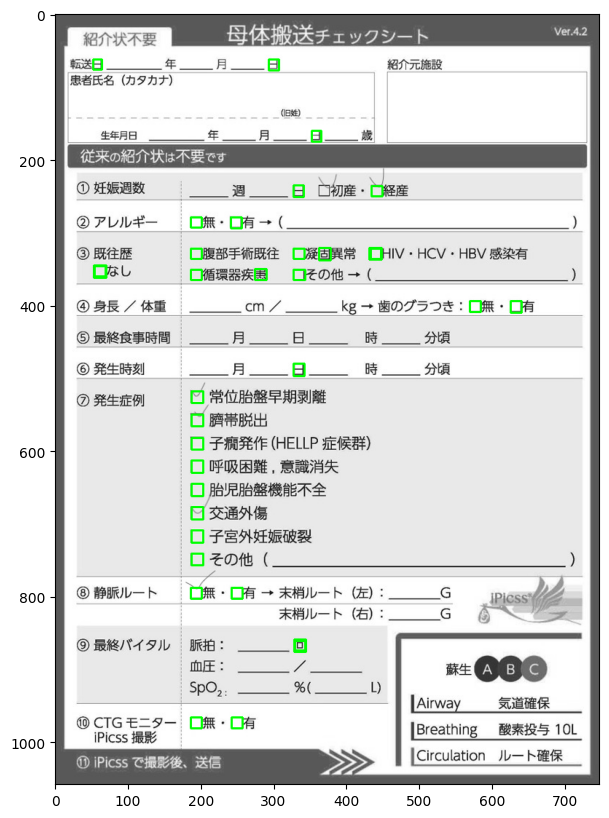

In [11]:
#検出処理
rects, grouping_rects, image, output_image = get_boxes(image, cfg=cfg, plot=False)

#検出結果の表示
plot_image(output_image)

In [25]:
# 認識したチェックボックスの画像を切り出して、管理しやすいようクラスで管理

rects: np.ndarray[np.ndarray[int]] #[[x1, y1, w, h], [x2, y2, w, h], ...]


def get_checkbox_image(rect: np.ndarray[int], image: Any) -> Any:
    """
    チェックボックスの画像を切り出す
    rect: np.ndarray[int] = [x, y, w, h]
    image: Any = 元画像
    """
    x, y, w, h = rect
    return image[y:y+h, x:x+w]

@dataclass
class Checkbox:
    rect: np.ndarray[int] #元画像内での座標情報
    image: Any #切り出したチェックボックスの画像

checkboxes: list[Checkbox] = []

for rect in rects:
    checkbox_image = get_checkbox_image(rect, image)
    checkbox = Checkbox(rect, checkbox_image)
    checkboxes.append(checkbox)

print(f'認識したチェックボックスの数：{len(checkboxes)}')



認識したチェックボックスの数：34


In [26]:
# 切り出した画像のピクセル値を2値化して、チェックマークがあるかどうかを判定する
def is_mark(checkbox: Checkbox, threshold: float) -> bool:
    """
    チェックボックスの画像からチェックマークがあるかどうかを判定する
    """
    # 画像を2値化
    _, binary_image = cv2.threshold(checkbox.image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # チェックマークの画像を読み込み
    mark_image = cv2.imread('mark.png', cv2.IMREAD_GRAYSCALE)

    # チェックマークの画像を2値化
    _, mark_image = cv2.threshold(mark_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # チェックマークの画像のピクセル値を取得
    mark_pixels = mark_image.flatten()



In [27]:
is_mark(checkboxes[0])

[ WARN:0@2259.209] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('mark.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'flatten'